# Treating correlated uncertainties with pyhf

## Introduction to HistFactory

[`pyhf`](https://pyhf.readthedocs.io) is a python implementation of the [`HistFactory`](https://cds.cern.ch/record/1456844/files/CERN-OPEN-2012-016.pdf) statistical model. This is a very general tool for statistical inference of binned data.

<p align="center">
  <img src="https://cds.cern.ch/record/2627611/files/Higgsto4l.png?subformat=icon-1440" />
</p>

Measurements in High Energy Physics (HEP) rely on determining the compatibility of observed collision events with theoretical predictions. The relationship between observed collision events and theoretical predictions is often formalised in a statistical model $f(\bm{x}|\bm{\phi})$ describing the probability of data $\bm{x}$ given model parameters $\bm{\phi}$,

$$
f(\bm{x}|\bm{\phi}) = f(\bm{x}|\overbrace{\bm{\eta}}^{\llap{\text{free}}},\underbrace{\bm{\chi}}_{\llap{\text{constrained}}}) = f(\bm{x}|\overbrace{\psi}^{\rlap{\text{parameters of interest}}},\underbrace{\theta}_{\rlap{\text{nuisance parameters}}}).
$$

Statistical models described using [`HistFactory`](https://cds.cern.ch/record/1456844/files/CERN-OPEN-2012-016.pdf) center around the simultaneous measurement of disjoint binned distributions (channels) observed as event counts $\bm{n}$,

$$
f(\bm{n}, \bm{a} \,|\,\bm{\eta},\bm{\chi}) = \underbrace{\prod_{c\in\mathrm{\,channels}} \prod_{b \in \mathrm{\,bins}_c}\textrm{Pois}\left(n_{cb} \,\middle|\, \nu_{cb}\left(\bm{\eta},\bm{\chi}\right)\right)}_{\substack{\text{Simultaneous measurement}\\%
  \text{of multiple channels}}} \underbrace{\prod_{\chi \in \bm{\chi}} c_{\chi}(a_{\chi} |\, \chi)}_{\substack{\text{constraint terms}\\%
  \text{for }\text{"auxiliary measurements"}}}.
$$

For each channel, the overall expected event rate is the sum over a number of physics processes (samples).


The expected rate of events $\nu_{cb}(\bm{\eta},\bm{\chi})$ as a function of unconstrained parameters $\bm{\eta}$ and constrained parameters $\bm{\chi}$. The latter has corresponding one-dimensional constraint terms $c_{\chi}(a_{\chi} |\, \chi)$ with auxiliary data $a_{\chi}$ constraining the parameter $\chi$. The event rates $\nu_{cb}$ are defined as

$$
\nu_{cb}\left(\bm{\phi}\right) = \sum_{s\in\mathrm{\,samples}} \nu_{scb}\left(\bm{\eta},\bm{\chi}\right) = \sum_{s\in\mathrm{\,samples}}\underbrace{\left(\prod_{\kappa\in\,\bm{\kappa}} \kappa_{scb}\left(\bm{\eta},\bm{\chi}\right)\right)}_{\text{multiplicative modifiers}}\, \Bigg(\nu_{scb}^0\left(\bm{\eta}, \bm{\chi}\right) + \underbrace{\sum_{\Delta\in\bm{\Delta}} \Delta_{scb}\left(\bm{\eta},\bm{\chi}\right)}_{\text{additive modifiers}}\Bigg)\,.
$$

The total rates are the sum over sample rates $\nu_{csb}$, each determined from a nominal rate $\nu_{scb}^0$ and a set of multiplicative and additive denoted rate modifiers $\bm{\kappa}(\bm{\phi})$ and $\bm{\Delta}(\bm{\phi})$. These modifiers are functions of (usually a single) model parameters.



Rate modifications are defined in [`HistFactory`](https://cds.cern.ch/record/1456844/files/CERN-OPEN-2012-016.pdf) for bin $b$, sample $s$, channel $c$. Each modifier is represented by a parameter $\phi \in \{\gamma, \alpha, \lambda, \mu\}$. $\sigma_b$ corresponds to the relative uncertainty of the event rate, whereas $\delta_b$ is the event rate uncertainty of the sample relative to the total event rate $\nu_b = \sum_s \nu^0_{sb}$.

![modifiers and constraints](https://pyhf.github.io/pyhf-tutorial/_images/modifiers_and_constraints.png)

## Correlated uncertainties

One feature that is not included in [`pyhf`](https://pyhf.readthedocs.io), is the correct treatment of arbitrarily correlated uncertainties. The current implementation features only fully (de)correlated uncertainties.

The use of this package is to add the option for arbitrarily correlated uncertainties, by a simple pre-processing step of the [`pyhf`](https://pyhf.readthedocs.io) model. The mathematical method used is [singular value decomposition (SVD)](https://www.cs.cmu.edu/~elaw/papers/pca.pdf).

To account for correlations between parameters, one simply adds a `correlation` field to the [`pyhf`](https://pyhf.readthedocs.io) model. Here we specify a `name`, which will be the new modifier name, the correlated variables `vars`, and the correlation matrix `corr`:

```python
spec = {
    "channels" : ...,
    "correlations": [
        {
            "name": "corr_1_2",
            "vars": ["unc1", "unc2"],
            "corr": [[1.0, 0.5], [0.5, 1.]],
        }
    ]
}
```

By pre-processing the model specification, we obtain a new specification, which is now [`pyhf`](https://pyhf.readthedocs.io) compatible and has the correlation correctly implemented:

```python
new_spec = pyhfcorr.decorrelate.decorrelate(spec)
```
We will use the `histosys` modifier for illustration below. The method applies just as well for the `shapesys`, `normsys` and `staterror`.

The `lumi, normfactor, shapefactor` modifiers, which contain no data, can only be fully (de)correlated and should be treated in [`pyhf`](https://pyhf.readthedocs.io) directly.

In [1]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
import pyhfcorr

In [2]:
# let's generate some toy histograms
bins = np.arange(11)
hist1 = np.array([2. , 3., 6.,  8.,  7., 7., 6., 2., 3., 1.])
hist2 = np.array([3. , 6., 9., 12., 15., 9., 6., 3., 3., 2.])

## Correlations within sample

First, we create a simple [`pyhf`](https://pyhf.readthedocs.io) model with one sample and two `histosys` modifiers.

In [3]:
samples = [
    {
        "name": "sample1",
        "data": (2*hist2).tolist(),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": (2*hist2-hist1).tolist(),
                    "hi_data": (2*hist2+hist1).tolist()
                }
            },
            {
                "name": "u2",
                "type": "histosys",
                "data": {
                    "lo_data": (2*hist2-hist2).tolist(),
                    "hi_data": (2*hist2+hist2).tolist()
                }
            }
        ],
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}
model = pyhf.Model(spec)


As a first example, we fully correlate `u1` and `u2` by adding a `correlations` entry and using `pyhfcorr.decorrelate.decorrelate` to obtain the [`pyhf`](https://pyhf.readthedocs.io) compatible spec:

In [4]:
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}],
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u2"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}
new_spec = pyhfcorr.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

Processing correlations ...


/home/lorenz/pyhfcorr/src/pyhfcorr/decorrelate.py:150: UserWarning: Modifier corr[1] is redundant and is not added.
  warnings.warn(f"Modifier {name} is redundant and is not added.")


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [6.0, 12.0, 18.0, 24.0, 30.0, 18.0, 12.0, 6.0, 6.0, 4.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'histosys',
       'data': {'lo_data': [1.0, 3.0, 3.0, 4.0, 8.0, 2.0, 0.0, 1.0, 0.0, 1.0],
        'hi_data': [11.0,
         21.0,
         33.0,
         44.0,
         52.0,
         34.0,
         24.0,
         11.0,
         12.0,
         7.0]},
       'name': 'corr[0]'}]}]}]}

We see that one parameter (`corr[0]`) was added to the model. In general, the number of parameters is invariant under SVD, but since we have a full correlation here, `pyhfcorr` does not add the redundant parameter `corr[1]`, and outputs a warning.

We can check that the data of the `corr[0]` modifier matches our expectations:

In [5]:
# lo_data
2*hist2-hist1-hist2

array([1., 3., 3., 4., 8., 2., 0., 1., 0., 1.])

In [6]:
# hi_data
2*hist2+hist1+hist2

array([11., 21., 33., 44., 52., 34., 24., 11., 12.,  7.])

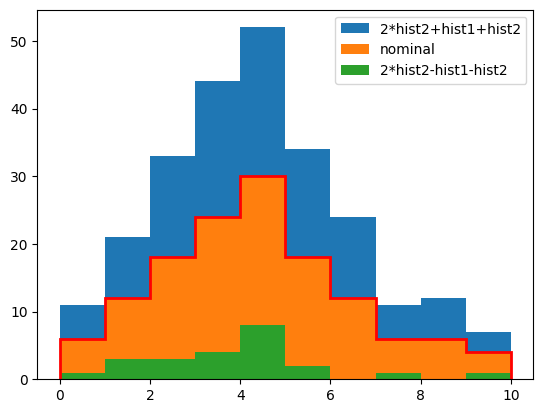

In [7]:
plt.stairs(2*hist2+hist1+hist2, bins, fill = True, label = "2*hist2+hist1+hist2")
plt.stairs(2*hist2, bins, fill=True, label = "nominal")
plt.stairs(2*hist2-hist1-hist2, bins, fill=True, label = "2*hist2-hist1-hist2")

initial_parameters = new_model.config.suggested_init()

# we can set corr[0] to (-1, 0, +1) to check the agreement with the expectation
initial_parameters[new_model.config.par_slice('corr[0]').start] = 0.

plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()
plt.show()

### A simple example with arbitrary correlation

In [8]:
corr = [[1., 0.1], [0.1, 1.]]
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}],
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u2"],
            "corr": corr,
        }
    ]}
new_spec = pyhfcorr.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

Processing correlations ...


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [6.0, 12.0, 18.0, 24.0, 30.0, 18.0, 12.0, 6.0, 6.0, 4.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'histosys',
       'data': {'lo_data': [2.2919007564521685,
         5.325421361613903,
         6.8757022693565055,
         9.167603025808674,
         13.68436332838954,
         6.134082420646939,
         3.1005618154852037,
         2.2919007564521685,
         1.5502809077426019,
         1.775140453871301],
        'hi_data': [9.708099243547831,
         18.674578638386098,
         29.124297730643494,
         38.832396974191326,
         46.31563667161046,
         29.86591757935306,
         20.899438184514796,
         9.708099243547831,
         10.449719092257398,
         6.224859546128699]},
       'name': 'corr[0]'},
      {'type': 'histosys',
       'data': {'lo_data': [5.329179606750063,
         9.98753882025019,
         15.9875388202501

**SVD** decomposes a correlation matrix $C$ as

$$ C = U S^2 U^H = USSU^H = (US)(US)^H,$$

where $U$ is a unitary transformation matrix, $UU^H=1$ and $S$ is the diagonal matrix of standard deviations, $S=S^H$.

In two dimensions this is rather simple:
- The correlation coefficient $\rho$ (offdiagonal element in $C$) tells us the amount of correlation long an axis rotated by $\pm \pi /4$, for positive/negative correlation, giving
$$
U = \frac{1}{\sqrt{2}}
\begin{pmatrix}
\pm 1 & \mp 1\\
\pm 1 & \pm1
\end{pmatrix}.
$$

- The scaling is just the square root of the eigenvalues of $C$,
$$
\sigma_\pm = \sqrt{1\pm \rho}.
$$

In [9]:
scale_factors = np.array([np.sqrt((1+corr[0][1])/2), np.sqrt((1-corr[0][1])/2)]).tolist()
scale_factors

[0.7416198487095663, 0.6708203932499369]

We can cross-check the `hi_data` the above modifiers:

In [10]:
print("corr[0] hi_data \n",
      2*hist2+scale_factors[0]*hist1+scale_factors[0]*hist2)

print("corr[1] hi_data \n",
      2*hist2-scale_factors[1]*hist1+scale_factors[1]*hist2)

corr[0] hi_data 
 [ 9.70809924 18.67457864 29.12429773 38.83239697 46.31563667 29.86591758
 20.89943818  9.70809924 10.44971909  6.22485955]
corr[1] hi_data 
 [ 6.67082039 14.01246118 20.01246118 26.68328157 35.36656315 19.34164079
 12.          6.67082039  6.          4.67082039]


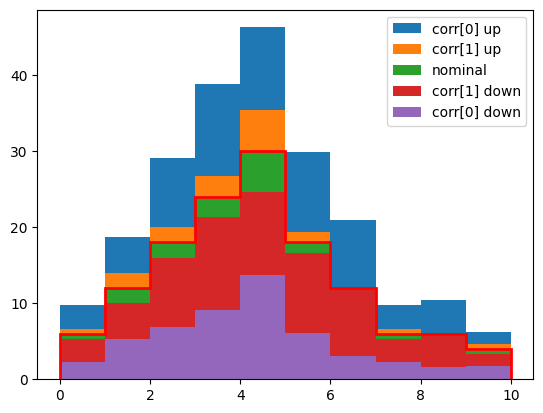

In [11]:
plt.stairs(2*hist2+scale_factors[0]*hist1+scale_factors[0]*hist2,
           bins, fill = True, label = "corr[0] up")
plt.stairs(2*hist2-scale_factors[1]*hist1+scale_factors[1]*hist2,
           bins, fill = True, label = "corr[1] up")
plt.stairs(2*hist2, bins, fill=True, label = "nominal")
plt.stairs(2*hist2+scale_factors[1]*hist1-scale_factors[1]*hist2,
           bins, fill = True, label = "corr[1] down")
plt.stairs(2*hist2-scale_factors[0]*hist1-scale_factors[0]*hist2,
           bins, fill = True, label = "corr[0] down")

initial_parameters = new_model.config.suggested_init()

# we can set corr[0] and corr[1] to (-1, 0, +1) to check the agreement with the expectation
initial_parameters[new_model.config.par_slice('corr[0]').start] = 0.
initial_parameters[new_model.config.par_slice('corr[1]').start] = 0.

plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()
plt.show()

## Correlations across channels/samples

We can also correlate parameters across different channels and/or samples:

In [12]:
samples = [
    {
        "name": "sample1",
        "data": (hist1).tolist(),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": (hist1-hist1).tolist(),
                    "hi_data": (hist1+hist1).tolist()
                }
            }
        ],
    },
    {
        "name": "sample2",
        "data": (hist2).tolist(),
        "modifiers": [
            {
                "name": "u2",
                "type": "histosys",
                "data": {
                    "lo_data": (hist2-hist1).tolist(),
                    "hi_data": (hist2+hist1).tolist()
                }
            }
        ],
    },
]
spec = {"channels" : [{"name" : "corrchannel", "samples" : samples}]}
model = pyhf.Model(spec)

In [13]:
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}],
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u2"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}

new_spec = pyhfcorr.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

Processing correlations ...


/home/lorenz/pyhfcorr/src/pyhfcorr/decorrelate.py:150: UserWarning: Modifier corr[1] is redundant and is not added.
  warnings.warn(f"Modifier {name} is redundant and is not added.")
/home/lorenz/pyhfcorr/src/pyhfcorr/decorrelate.py:150: UserWarning: Modifier corr[1] is redundant and is not added.
  warnings.warn(f"Modifier {name} is redundant and is not added.")


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [2.0, 3.0, 6.0, 8.0, 7.0, 7.0, 6.0, 2.0, 3.0, 1.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'histosys',
       'data': {'lo_data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        'hi_data': [4.0, 6.0, 12.0, 16.0, 14.0, 14.0, 12.0, 4.0, 6.0, 2.0]},
       'name': 'corr[0]'}]},
    {'name': 'sample2',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.0, 2.0],
     'modifiers': [{'type': 'histosys',
       'data': {'lo_data': [1.0, 3.0, 3.0, 4.0, 8.0, 2.0, 0.0, 1.0, 0.0, 1.0],
        'hi_data': [5.0, 9.0, 15.0, 20.0, 22.0, 16.0, 12.0, 5.0, 6.0, 3.0]},
       'name': 'corr[0]'}]}]}]}

In this case, we see that one `corr[0]` modifier was added to each of the samples. Since they have the same name, [`pyhf`](https://pyhf.readthedocs.io) will treat them as fully correlated.

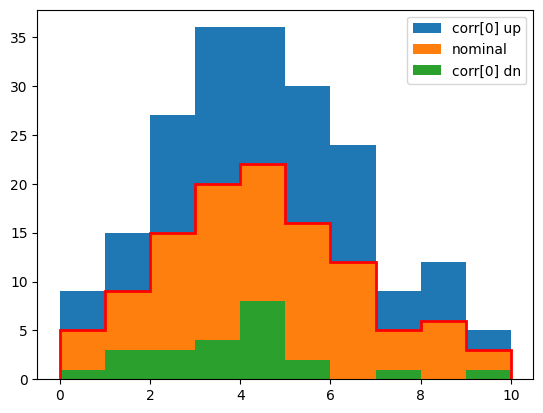

In [14]:
plt.stairs(hist1 + hist1 + hist2 + hist1, bins, fill = True, label = "corr[0] up")
plt.stairs(hist2 + hist1, bins, fill = True, label = "nominal")
plt.stairs(hist1 - hist1 + hist2 - hist1, bins, fill=True, label = "corr[0] dn")

initial_parameters = new_model.config.suggested_init()

# we can set corr[0] to (-1, 0, +1) to check the agreement with the expectation
initial_parameters[new_model.config.par_slice('corr[0]').start] = 0.

plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()
plt.show()

## A slightly more complicated example



In [15]:
samples = [
    {
        "name": "sample1",
        "data": (hist1).tolist(),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": (hist1-hist1/2).tolist(),
                    "hi_data": (hist1+hist1/2).tolist()
                }
            },
            {
                "name": "u12",
                "type": "histosys",
                "data": {
                    "lo_data": (hist1-hist2/2).tolist(),
                    "hi_data": (hist1+hist2/2).tolist()
                }
            }
        ],
    },
    {
        "name": "sample2",
        "data": (hist2).tolist(),
        "modifiers": [
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": (hist2-hist1/3).tolist(),
                    "hi_data": (hist2+hist1/3).tolist()
                }
            },
            {
                "name": "u2",
                "type": "histosys",
                "data": {
                    "lo_data": (hist2-hist2/3).tolist(),
                    "hi_data": (hist2+hist2/3).tolist()
                }
            }
        ],
    },
]
spec = {"channels" : [{"name" : "corrchannel", "samples" : samples}]}
model = pyhf.Model(spec)


In [16]:
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}],
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u12", "u2"],
            "corr": [[1., 1., -1.], [1., 1., -1.], [-1., -1., 1.]],
        }
    ]}

new_spec = pyhfcorr.decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

Processing correlations ...


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [2.0, 3.0, 6.0, 8.0, 7.0, 7.0, 6.0, 2.0, 3.0, 1.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'type': 'histosys',
       'data': {'lo_data': [-0.4999999999999991,
         -1.4999999999999982,
         -1.4999999999999982,
         -1.9999999999999964,
         -3.9999999999999964,
         -0.9999999999999982,
         8.881784197001252e-16,
         -0.4999999999999991,
         4.440892098500626e-16,
         -0.49999999999999956],
        'hi_data': [4.499999999999999,
         7.499999999999998,
         13.499999999999998,
         17.999999999999996,
         17.999999999999996,
         14.999999999999998,
         12.0,
         4.499999999999999,
         6.0,
         2.4999999999999996]},
       'name': 'corr[0]'},
      {'type': 'histosys',
       'data': {'lo_data': [2.000000001140177,
         2.9999999936754413,
         6.00000000342053,
         

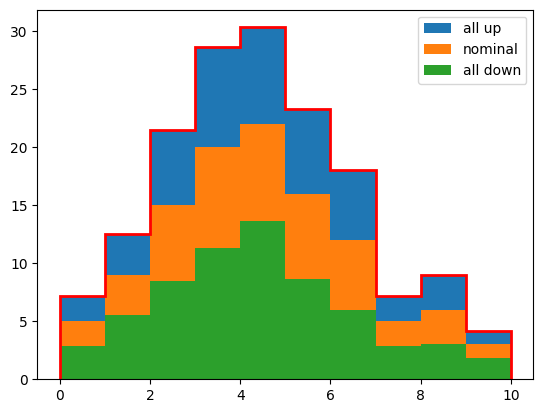

In [17]:
all_up = hist1 + (hist1 + hist2)/2 + hist2 + (hist1 - hist2)/3
nominal = hist2 + hist1
all_dn = hist1 - (hist1 + hist2)/2 + hist2 - (hist1 - hist2)/3
plt.stairs(all_up, bins, fill = True, label = "all up")
plt.stairs(nominal, bins, fill = True, label = "nominal")
plt.stairs(all_dn, bins, fill = True, label = "all down")

initial_parameters = new_model.config.suggested_init()

# we can set corr[0] to (-1, 0, +1) to check the agreement with the expectation
initial_parameters[new_model.config.par_slice('corr[0]').start] = 1
plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()
plt.show()

In [18]:
par_names = new_model.config.par_names
pyhf.set_backend('numpy',  'minuit')
best_fit = pyhf.infer.mle.fixed_poi_fit(1, all_up.tolist() + model.config.auxdata, new_model, return_uncertainties=True)

for p, v in zip(par_names, best_fit):
    print(p, f'{v[0]:.2f} +/- {v[1]:.2f}')

corr[0] 0.94 +/- 0.25
corr[1] 0.00 +/- 0.99
corr[2] 0.00 +/- 0.99
mu 1.00 +/- 0.00


## Final remarks

- We can now treat arbitrary correlations between parameters for [`pyhf`](https://pyhf.readthedocs.io) models.
- The pre-processing approach makes it fast and efficient.
- No additional dependencies, once model parameters are decorrelated.
- Easy installation with `pip install pyhfcorr`.
- `pre-commit` set up for linting.
- [Tests](test) implemented for standardized cases.
- CI set up to automatically run tests with `github actions`.
- Merge into [`pyhf`](https://pyhf.readthedocs.io) in discussion - [#2463](https://github.com/scikit-hep/pyhf/issues/2463).

Check out the [repository](https://github.com/lorenzennio/pyhfcorr)

Feedback welcome: [File issue on GitHub](https://github.com/lorenzennio/pyhfcorr/issues/new/choose)